
# Prediction with a pre-trained model 

In [1]:
from keras.models import load_model
from unet3 import *

# load json and create model 
json_file = open('model/model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/pretrained_model.hdf5")
print("Loaded model from disk")

# training image dimensions
n1, n2, n3 = 128, 128, 128

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loaded model from disk


In [2]:
# set gaussian weights in the overlap bounaries
def getMask(os):
    sc = np.zeros((n1,n2,n3),dtype=np.single)
    sc = sc+1
    sp = np.zeros((os),dtype=np.single)
    sig = os/4
    sig = 0.5/(sig*sig)
    for ks in range(os):
        ds = ks-os+1
        sp[ks] = np.exp(-ds*ds*sig)
    for k1 in range(os):
        for k2 in range(n2):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k1]
                sc[n1-k1-1][k2][k3]=sp[k1]
    for k1 in range(n1):
        for k2 in range(os):
            for k3 in range(n3):
                sc[k1][k2][k3]=sp[k2]
                sc[k1][n3-k2-1][k3]=sp[k2]
    for k1 in range(n1):
        for k2 in range(n2):
            for k3 in range(os):
                sc[k1][k2][k3]=sp[k3]
                sc[k1][k2][n3-k3-1]=sp[k3]
    return sc

## ======================================================================


## prediction test on a training image 


1/1 [==============================] - 1s 837ms/step


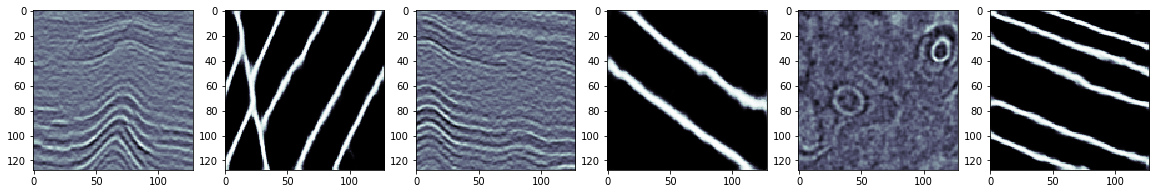

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

gx,m1,m2,m3 = np.fromfile("data/train/seis/8.dat",dtype=np.single),128,128,128
gx = gx-np.min(gx)
gx = gx/np.max(gx)
gx = gx*255
k = 50
x = np.reshape(gx,(1,n1,n2,n3,1))
Y = loaded_model.predict(x,verbose=1)
fig = plt.figure(figsize=(20,20))
#inline slice
k1 = 50
plt.subplot(1, 6, 1)
imgplot1 = plt.imshow(np.transpose(x[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 2)
imgplot2 = plt.imshow(np.transpose(Y[0,k,:,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
#xline slice
k2 = 110
plt.subplot(1, 6, 3)
imgplot1 = plt.imshow(np.transpose(x[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 4)
imgplot2 = plt.imshow(np.transpose(Y[0,:,k2,:,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)

#time slice
k3 = 60
plt.subplot(1, 6, 5)
imgplot1 = plt.imshow(np.transpose(x[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)
plt.subplot(1, 6, 6)
imgplot2 = plt.imshow(np.transpose(Y[0,:,:,k3,0]),cmap=plt.cm.bone,interpolation='nearest',aspect=1)

 
## ======================================================================

## prediction test on a field seismic image extracted from

## the Netherlands off-shore F3 block seismic data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

#a 3d array of gx[m1][m2][m3], please make sure the dimensions are correct!!!
#we strongly suggest to gain the seismic image before input it to the faultSeg!!!
gx,m1,m2,m3 = np.fromfile("data/prediction/f3d/gxl.dat",dtype=np.single),512,384,128
os = 12 #overlap width
c1 = np.round((m1+os)/(n1-os)+0.5)
c2 = np.round((m2+os)/(n2-os)+0.5)
c3 = np.round((m3+os)/(n3-os)+0.5)
c1 = int(c1)
c2 = int(c2)
c3 = int(c3)
p1 = (n1-os)*c1+os
p2 = (n2-os)*c2+os
p3 = (n3-os)*c3+os
gx = np.reshape(gx,(m1,m2,m3))
gp = np.zeros((p1,p2,p3),dtype=np.single)
gy = np.zeros((p1,p2,p3),dtype=np.single)
mk = np.zeros((p1,p2,p3),dtype=np.single)
gs = np.zeros((1,n1,n2,n3,1),dtype=np.single)
gp[0:m1,0:m2,0:m3]=gx
sc = getMask(os)
for k1 in range(c1):
    for k2 in range(c2):
        for k3 in range(c3):
            b1 = k1*n1-k1*os
            e1 = b1+n1
            b2 = k2*n2-k2*os
            e2 = b2+n2
            b3 = k3*n3-k3*os
            e3 = b3+n3
            gs[0,:,:,:,0]=gp[b1:e1,b2:e2,b3:e3]
            gs = gs-np.min(gs)
            gs = gs/np.max(gs)
            gs = gs*255
            Y = loaded_model.predict(gs,verbose=1)
            Y = np.array(Y)
            gy[b1:e1,b2:e2,b3:e3]= gy[b1:e1,b2:e2,b3:e3]+Y[0,:,:,:,0]*sc
            mk[b1:e1,b2:e2,b3:e3]= mk[b1:e1,b2:e2,b3:e3]+sc
gy = gy/mk
gy = gy[0:m1,0:m2,0:m3]
gy.tofile("data/prediction/f3d/"+"fp.dat",format="%4")

1/1 [==============================] - 1s 725ms/step


### Output images are different !

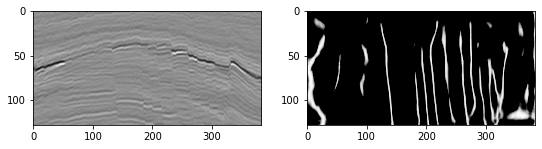

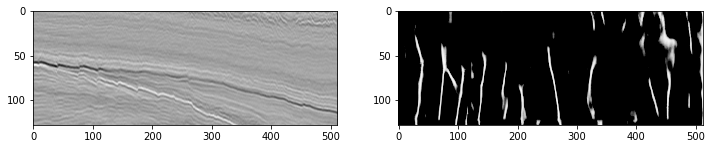

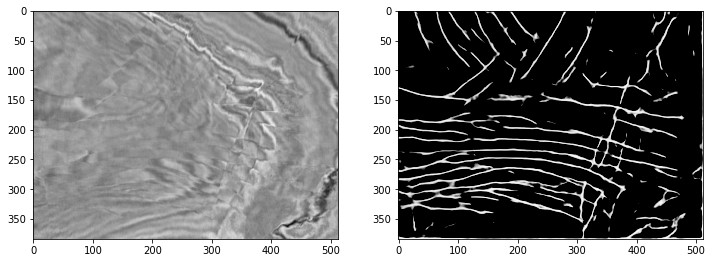

In [5]:
from matplotlib.colors import Normalize
from PIL import Image
gx,m1,m2,m3 = np.fromfile("data/prediction/f3d/gxl.dat",dtype=np.single),512,384,128
gy.tofile("data/prediction/f3d/"+"fp.dat",format="%4")
gx = np.reshape(gx,(m1,m2,m3))
gy = np.reshape(gy,(m1,m2,m3))

k1,k2,k3 = 29,29,99
gx1 = np.transpose(gx[k1,:,:])
gy1 = np.transpose(gy[k1,:,:])
gx2 = np.transpose(gx[:,k2,:])
gy2 = np.transpose(gy[:,k2,:])
gx3 = np.transpose(gx[:,:,k3])
gy3 = np.transpose(gy[:,:,k3])

#xline slice
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)

#time slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)


In [6]:
!pip freeze

absl-py==0.9.0
astor==0.8.1
attrs==19.3.0
backcall==0.1.0
bleach==3.1.4
certifi==2019.11.28
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
entrypoints==0.3
gast==0.2.2
google-pasta==0.2.0
grpcio==1.28.0
h5py==2.10.0
imageio==2.8.0
importlib-metadata==1.6.0
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
jedi==0.16.0
Jinja2==2.11.1
json5==0.9.4
jsonschema==3.2.0
jupyter-client==6.1.2
jupyter-core==4.6.3
jupyterlab==2.0.1
jupyterlab-server==1.0.7
Keras==2.3.1
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.0
kiwisolver==1.2.0
Markdown==3.2.1
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
nbconvert==5.6.1
nbformat==5.0.5
networkx==2.4
notebook==6.0.3
numpy==1.18.2
opt-einsum==3.2.0
pandocfilters==1.4.2
parso==0.6.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.1.2
progress==1.5
prometheus-client==0.7.1
prompt-toolkit==3.0.5
protobuf==3.6.1
ptyprocess==0.6.0
Pygments==2.6.1
pyparsing==2.4.7
pyrsistent==0.16.0
python-dateutil==2.8.1
PyWavelets==1.1.1
PyYAML==5.3.1
pyzmq==19

In [7]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              28
On-line CPU(s) list: 0-27
Thread(s) per core:  2
Core(s) per socket:  14
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Core(TM) i9-7940X CPU @ 3.10GHz
Stepping:            4
CPU MHz:             1200.257
CPU max MHz:         4400.0000
CPU min MHz:         1200.0000
BogoMIPS:            6199.99
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            19712K
NUMA node0 CPU(s):   0-27
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx est tm2 ssse